In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

In [34]:
df = pd.read_csv('/Users/devarshee/Desktop/Datathon/accessibility_coordinates_preprocessed.csv')
df.head()


,longitude,latitude,issue_type,severity,X,Y,population_total,children_under_18,working_age_adults,older_adults_65_over,median_age,pct_children,pct_older_adults,vulnerability_index
0,-122.298981,47.594616,SurfaceProblem,4.0,1.278807e+06,220339.305108,23800,3939,16749,3112,40.3,0.165504,0.130756,0.296261
1,-122.301071,47.593357,SurfaceProblem,3.0,1.278282e+06,219890.033975,23800,3939,16749,3112,40.3,0.165504,0.130756,0.296261
2,-122.301079,47.596844,SurfaceProblem,4.0,1.278304e+06,221161.640591,23800,3939,16749,3112,40.3,0.165504,0.130756,0.296261
3,-122.301071,47.596500,SurfaceProblem,4.0,1.278304e+06,221036.395318,23800,3939,16749,3112,40.3,0.165504,0.130756,0.296261
4,-122.306274,47.599930,NoCurbRamp,4.0,1.277044e+06,222311.623280,23800,3939,16749,3112,40.3,0.165504,0.130756,0.296261


In [9]:
# Drop any remaining rows with missing severity (edge case from imputation)
df = df.dropna(subset=['severity'])

# Encode issue_type
le = LabelEncoder()
df['issue_type_encoded'] = le.fit_transform(df['issue_type'])

# Features & target (include demographics if available)
base_features = ['X', 'Y', 'issue_type_encoded']
demo_features = ['pct_children', 'pct_older_adults', 'vulnerability_index', 'median_age']
feature_cols = base_features + [c for c in demo_features if c in df.columns]
X = df[feature_cols]
y = df['severity']

# Train/test split
# Note: stratify omitted because severity can have float values (e.g. 2.5 from imputation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 65376, Test: 16344


In [ ]:
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
_ = rf.fit(X_train, y_train)

In [ ]:
# Evaluate on test set
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.3209
RMSE: 0.5314
R²:   0.7785


In [ ]:
# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

importance

,feature,importance
2,issue_type_encoded,0.579534
0,X,0.213136
1,Y,0.207330


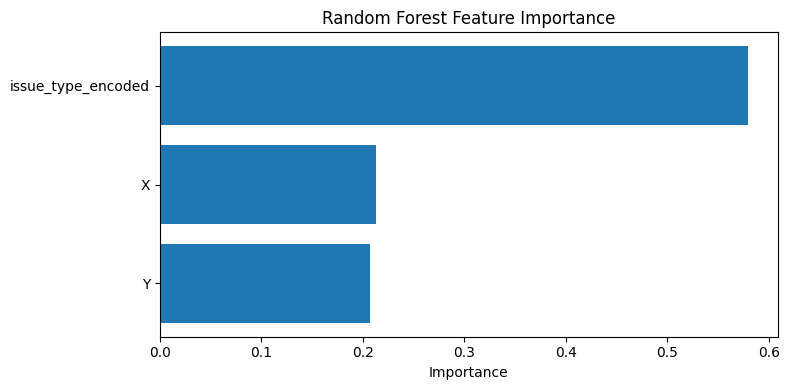

In [ ]:
# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_grid, n_iter=20, cv=3, scoring='r2', random_state=42)
search.fit(X_train, y_train)
best_rf = search.best_estimator_

---
## XGBoost

In [20]:
# Train XGBoost Regressor
model_xgb = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42)
_ = model_xgb.fit(X_train, y_train)

In [21]:
# Evaluate XGBoost on test set
y_pred_xgb = model_xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE:  {mae_xgb:.4f}")
print(f"XGBoost - RMSE: {rmse_xgb:.4f}")
print(f"XGBoost - R²:   {r2_xgb:.4f}")

XGBoost - MAE:  0.4034
XGBoost - RMSE: 0.5684
XGBoost - R²:   0.7465


In [22]:
# XGBoost feature importance
importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

importance_xgb

,feature,importance
2,issue_type_encoded,0.897875
0,X,0.053508
1,Y,0.048617


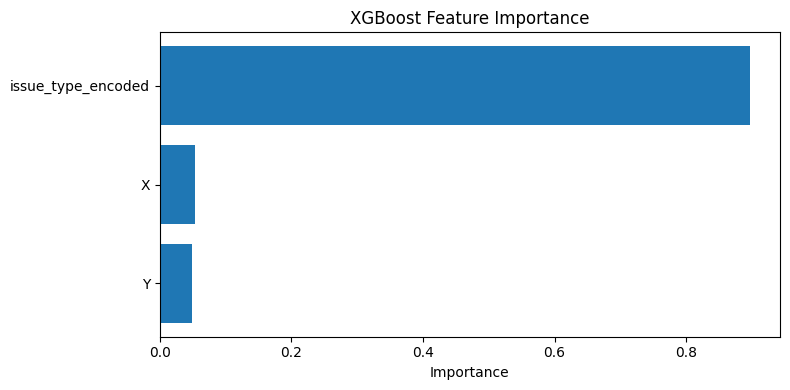

In [23]:
# Plot XGBoost feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(importance_xgb['feature'], importance_xgb['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## LightGBM

In [29]:
# Train LightGBM Regressor
model_lgb = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42)
_ = model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 65376, number of used features: 3
[LightGBM] [Info] Start training from score 2.681420


In [30]:
# Evaluate LightGBM on test set
y_pred_lgb = model_lgb.predict(X_test)

mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM - MAE:  {mae_lgb:.4f}")
print(f"LightGBM - RMSE: {rmse_lgb:.4f}")
print(f"LightGBM - R²:   {r2_lgb:.4f}")

LightGBM - MAE:  0.4630
LightGBM - RMSE: 0.6118
LightGBM - R²:   0.7063


In [31]:
# LightGBM feature importance
importance_lgb = pd.DataFrame({
    'feature': X.columns,
    'importance': model_lgb.feature_importances_
}).sort_values('importance', ascending=False)

importance_lgb

,feature,importance
1,Y,2616
0,X,2441
2,issue_type_encoded,943


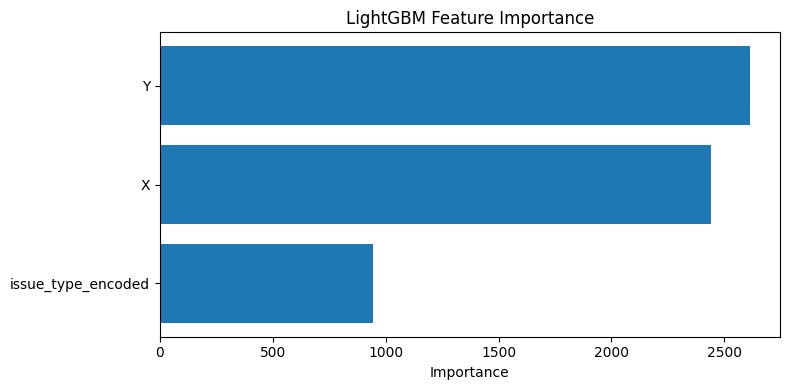

In [32]:
# Plot LightGBM feature importance
plt.figure(figsize=(8, 4))
plt.barh(importance_lgb['feature'], importance_lgb['importance'])
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()